In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from math import isclose
from random import randint

In [2]:
class CosmicBody:
    array = []
    shouldDestroyed = False
    
    def __init__(self, mass: float, speed: np.ndarray, position: np.ndarray):
        self.mass = mass
        self.speed = speed
        self.position = position
        self.route = [position]
        
    def move(self, timeDiff: float):
        '''Просчитывает положение тела через время timeDiff'''
        # Расчёт гравитационных взаимодействий
        deltaSpeed = np.zeros(3)
        
        for body in CosmicBody.array:
            # На самого себя сила тяготения не действует
            if body == self:
                continue
                
            # Расчёт изменения скорости от силы тяготения
            r = body.position - self.position
            
            rLength = (r[0] ** 2 + r[1] ** 2 + r[2] ** 2) ** 0.5
            deltaSpeed = deltaSpeed + r * body.mass / rLength ** 3 * timeDiff
            
        deltaSpeed = deltaSpeed * 6.6743015 / (10 ** 11)
        
        # Изменение положения в пространстве
        self.position = self.position + self.speed * timeDiff + deltaSpeed * (timeDiff ** 2) / 2
        
        # Запись новой позиции в путь для построения на графике
        self.route.append(self.position)
        
    def draw(self, ax):
        '''Отрисовывает пути и точки пройденные телом'''
        # Преобразование массива векторов к массивам с координатами для matplotlib
        xs = []
        ys = []
        zs = []
        for point in self.route:
            xs.append(point[0])
            ys.append(point[1])
            zs.append(point[2])
        
        ax.plot(xs, ys, zs)
        ax.scatter(xs, ys, zs)
        
    def collision(self):
        '''Обрабатывает столкновения тел'''
        for body in CosmicBody.array:
            
            if body == self:
                continue
            
            a = self.route[-1]
            b = self.route[-2] if len(self.route) >= 2 else a
            
            # Если объект прошёл через другой - значит последние точки первого лежат
            # слева и справа от координат второго
            
            # Расчёт левой и правой точек
            xLeft = min(a[0], b[0])
            xRight = max(a[0], b[0])
            yLeft = min(a[1], b[1])
            yRight = max(a[1], b[1])
            zLeft = min(a[2], b[2])
            zRight = max(a[2], b[2])
            
            #Проверка на прохождение через объект
            if xLeft <= body.position[0] <= xRight and \
            yLeft <= body.position[1] <= yRight and \
            zLeft <= body.position[2] <= zRight:
                # Уничтожается объект с наименьшей массой
                if self.mass < body.mass:
                    self.route[-1] = body.position
                    self.shouldDestroyed = True
                else:
                    body.shouldDestroyed = True
                
    def destroy(self):
        '''Уничтожает объект если shouldDestroyed = True'''
        if(self.shouldDestroyed):
            CosmicBody.array.remove(self)
            
    def detectTrajectory(self, body):
        '''Получает тип траектории для текущего объекта относительно body'''
        r = self.position - body.position
        rModule = (r[0] ** 2 + r[1] ** 2 + r[2] ** 2) ** 0.5
        
        # Если расстояние == 0, то точка лежит внутри другой
        if isclose(rModule, 0):
            return "лежит внутри"
        
        speedModule = (self.speed[0] ** 2 + self.speed[1] ** 2 + self.speed[2] ** 2) ** 0.5
        
        # Остальное считаем по формуле (3)
        e = self.mass * speedModule ** 2 / 2 + self.mass * body.mass / rModule *6.6743015 / (10 ** 11)
        if e > 0:
            return "гипербола"
        if e == 0:
            return "парабола"
        if e < 0:
            return "эллипс"

In [3]:
class Star(CosmicBody):
    '''Звезда - такое же космическое тело, только нулевой скоростью и нулевыми координатами'''
    def __init__(self, mass: float):
        super().__init__(mass, np.zeros((3)), np.zeros((3)))

In [4]:
def test_before():
    CosmicBody.array.append(CosmicBody(10, np.array([1, 2, 3]), np.array([4, 5, 6])))
    CosmicBody.array.append(CosmicBody(10000000, np.array([4, 5, 6]), np.array([1, 2, 3])))
test_before()

In [5]:
def test_move():
    '''Тест перемещения тел'''
    CosmicBody.array[1].move(2e-2)
    assert np.isclose(CosmicBody.array[1].position, np.array([1.08, 2.1, 3.12])).all()
test_move()

In [6]:
def test_detectTrajectory():
    assert CosmicBody.array[1].detectTrajectory(CosmicBody.array[0]) == 'гипербола'
test_detectTrajectory()

In [7]:
def test_after():
    CosmicBody.array = []
test_after()

<IPython.core.display.Javascript object>


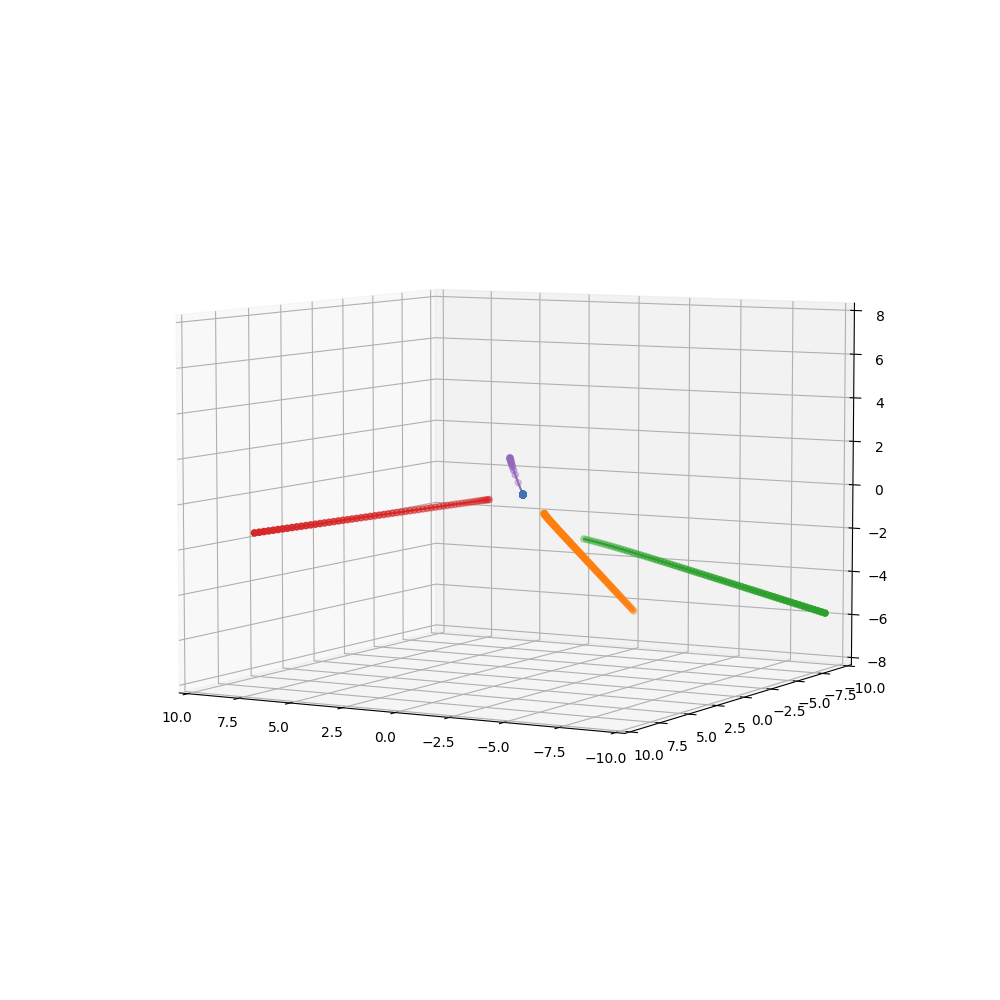

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.12it/s]


In [8]:
# Магическая строка для корректного отображения анимации
%matplotlib notebook
# Создаем фигуру 
fig = plt.figure(figsize=(10, 10))
# Добавляем на нее объект Axes3D для отображения графиков в 3D
ax = fig.add_subplot(111, projection='3d')
# Задаем границы
ax.axes.set_xlim3d(-10, 10)
ax.axes.set_ylim3d(-10, 10)
ax.axes.set_zlim3d(-10, 10)    

# Отображаем пустую фигуру
fig.show()
fig.canvas.draw()

# Кладём в массив CosmicBody тела для симуляции
# Большая масса у Star для эффектности
CosmicBody.array.append(Star(10000000000000))

timeDiff = 1e-1
timeEnd = 10

for time in tqdm(np.arange(0., timeEnd, timeDiff)):
    angle = 60 + 60 * time / timeEnd
    # Удаляем графики, отображенные на предыдущем шаге
    ax.clear()
    # Задаем границы, потому что они скидываются на дефолтные
    ax.axes.set_xlim3d(-10, 10)
    ax.axes.set_ylim3d(-10, 10)
    ax.axes.set_zlim3d(-8, 8)
    
    # Каждую 2 единицу времени кладём новый объект для симуляции
    if isclose(time % 1, 0):
        CosmicBody.array.append(CosmicBody(10000000, np.random.standard_normal(3,), np.random.standard_normal(3,)))    
    
    for body in CosmicBody.array:
        body.move(timeDiff)
        body.collision()
        body.draw(ax)
        body.destroy()
    
    # Изменяем угол отображения графика
    ax.view_init(30 - angle * 0.2, angle)
    # Перерисовываем фигуру
    fig.canvas.draw()